In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from PIL import Image


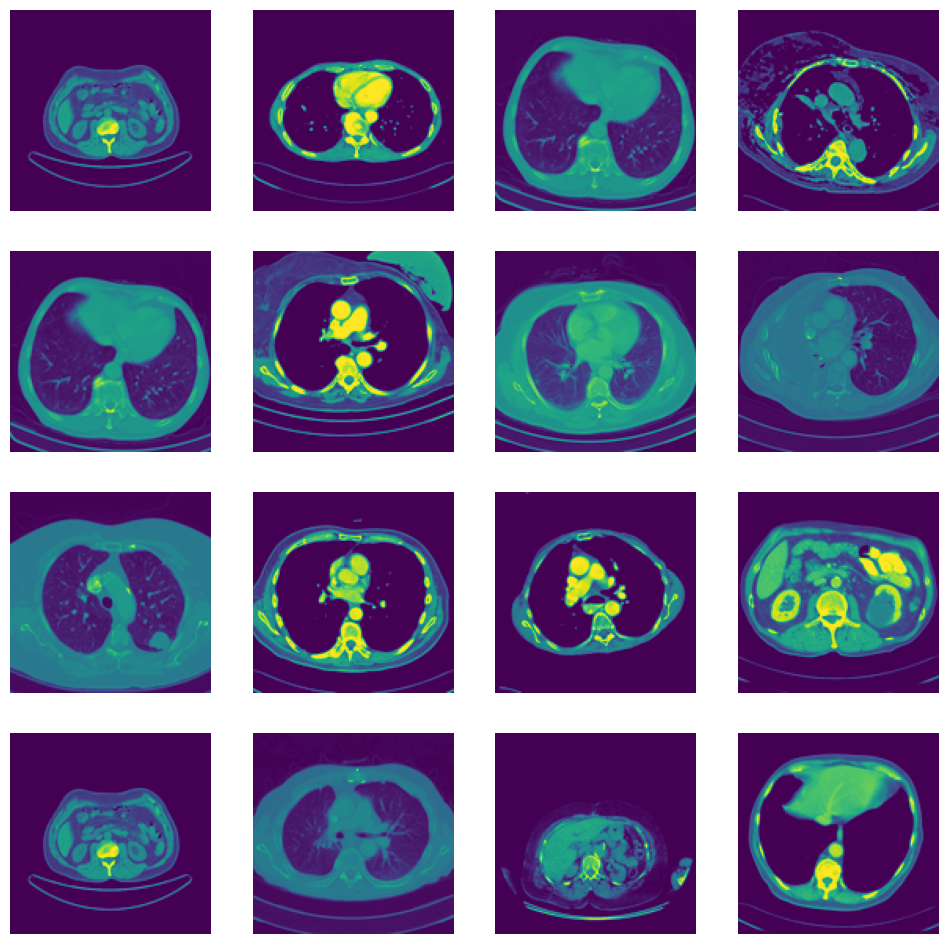

In [25]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        img = Image.open(os.path.join(directory, filename))
        img = img.resize((128, 128))
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

data_directory = 'Dataset/Images'
train_images = load_images(data_directory)

# Display the first 16 images
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_images[i])
    plt.axis('off')
plt.show()


In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32 * 32 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256)

    model.add(layers.Conv2D(128, (5, 5), strides=(7, 7), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(64, (5, 5), strides=(3, 3), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    return model

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(4, 4), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    images = tf.reshape(images, [-1, 128, 128, 1])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 64

generator = make_generator_model()
discriminator = make_discriminator_model()


generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    for image_batch in train_images:
        train_step(image_batch)



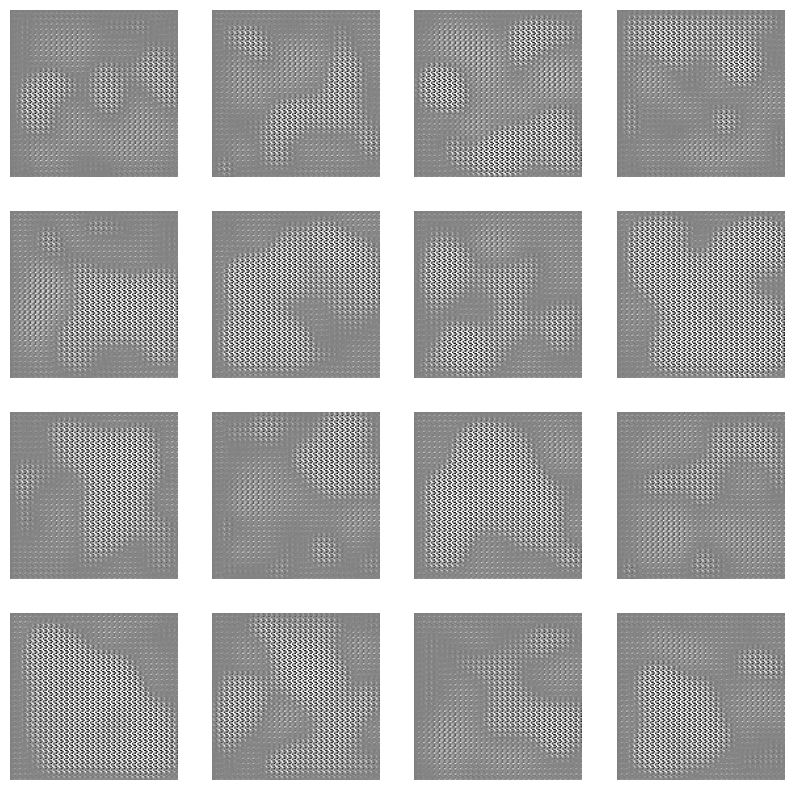

In [17]:
import matplotlib.pyplot as plt

def generate_images(generator, noise_dim, num_examples_to_generate):
    noise = tf.random.normal([num_examples_to_generate, noise_dim])
    generated_images = generator(noise, training=False)
    return generated_images

generated_images = generate_images(generator, noise_dim, num_examples_to_generate)

plt.figure(figsize=(10, 10))
for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


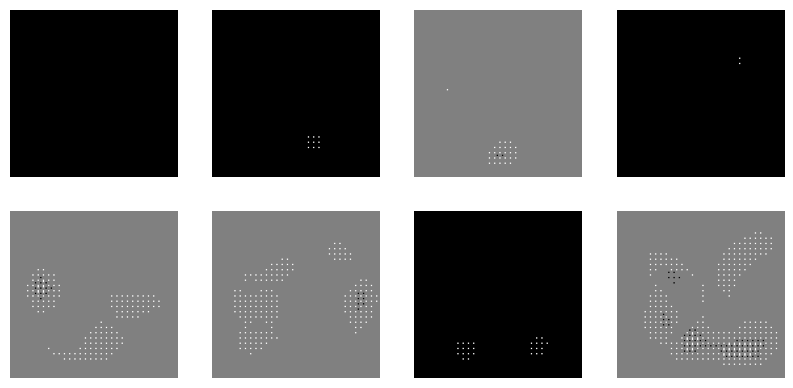

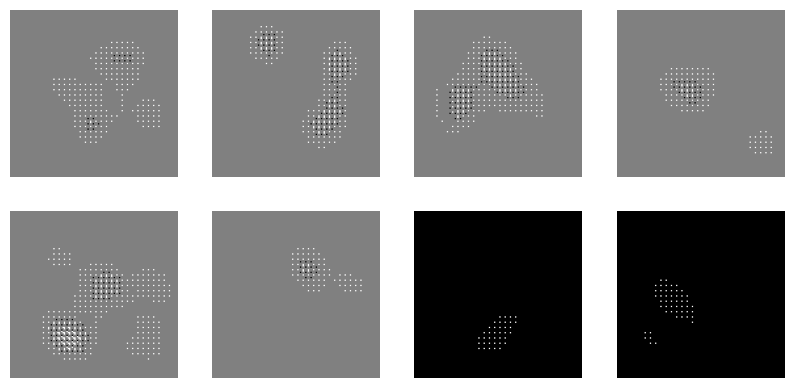

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


def generate_private_key(generator, noise_dim, num_examples_to_generate):
    noise = tf.random.normal([num_examples_to_generate, noise_dim])
    private_key = generator(noise, training=False)
    return private_key

batch_size = 8
num_batches = num_examples_to_generate // batch_size

for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = min((batch_index + 1) * batch_size, num_examples_to_generate)

    generated_private_key = generate_private_key(generator, noise_dim, end_index - start_index)
    generated_images_batch = generated_images[start_index:end_index]

    generated_images_batch = np.array(generated_images_batch)
    generated_private_key = np.array(generated_private_key)

    tf.keras.backend.clear_session()

    reshaped_private_key = np.resize(generated_private_key, (8, 128, 128, 1))

    generated_images_batch = generated_images_batch.astype(np.int32)
    reshaped_private_key = reshaped_private_key.astype(np.int32)

    encrypted_images_batch = np.bitwise_xor(generated_images_batch, reshaped_private_key)

    plt.figure(figsize=(10, 10))
    for i in range(end_index - start_index):
        plt.subplot(4, 4, i+1)
        plt.imshow(encrypted_images_batch[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()
